In [742]:
import numpy as np 
import torch 
import torch.nn as nn 

import pandas as pd 
from tqdm import trange 
import matplotlib.pyplot as plt 

In [743]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
torch.set_default_device(device) 
torch.set_default_dtype(torch.float64) # Numerical stability 

In [744]:
class Set: 

    def __init__(self, set_size, warehouse_size, batch_size): 
        self.S = torch.zeros((batch_size, warehouse_size)) # Initially empty  
        self.W = torch.arange(warehouse_size) # {1, 2, ..., m} 
        self.batch_size = batch_size 
        self.batch_ids = torch.arange(self.batch_size) 
        self.set_size = set_size 
        self.stopped = torch.zeros((self.batch_size,)) # Whether the generative process is finished 

    @torch.no_grad() 
    def apply(self, indices): 
        elements_to_add = self.W[indices] 
        self.S[self.batch_ids, elements_to_add] = 1. 
        self.stopped += (self.S.sum(dim=1) == self.set_size) 
        assert (self.S.sum(dim=1) <= self.set_size).all(), (self.S.sum(dim=1), self.set_size, self.W, self.stopped) 
        # Return an indicator of whether the generative process is finished 
        return (self.stopped <= 1.) 

In [745]:
class ForwardPolicy(nn.Module): 
    masked_value = -1e5 # To mask unwanted actions (e.g., adding an element twice)  
    eps = .3 # For off-policy exploration 

    def __init__(self, warehouse_size, hidden_dim):
        super(ForwardPolicy, self).__init__() 
        self.warehouse_size = warehouse_size 
        self.mlp = nn.Sequential(
            nn.Linear(warehouse_size, hidden_dim), nn.LeakyReLU(), 
            nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(), 
            nn.Linear(hidden_dim, warehouse_size)) 
    
    def forward(self, state: Set):
        S = state.S.clone() 
        rep = self.mlp(S) 
        # Mask the already added values 
        rep = (1 - S) * rep + S * self.masked_value 
        policy = torch.softmax(rep, dim=-1)

        # Sample actions from an exploratory policy 
        eps = 0. if not self.training else self.eps # Off-policy only during training 
        unf_policy = (1 - S) / (1 - S).sum(dim=1, keepdims=True) # Uniform policy  
        exp_policy = policy * (1 - eps) + unf_policy * eps 
        actions = torch.multinomial(exp_policy, num_samples=1, replacement=True)
        actions = actions.squeeze() 
        
        # Return the actions and the corresponding forward probabilities 
        return actions, torch.log(policy[state.batch_ids, actions])

In [746]:
class BackwardPolicy(nn.Module): 

    def forward(self, state, actions): 
        S = state.S.clone() 
        # The backward policy is fixed as uniform 
        return - torch.log(S.sum(dim=1)) 

In [747]:
class LogReward(nn.Module): 

    def __init__(self, warehouse_size, seed=42, device='cuda'): 
        super(LogReward, self).__init__() 
        #g = torch.Generator(device=device) 
        #g.manual_seed(seed) 
        #self.r = torch.rand(warehouse_size, generator=g) 
        # make self.r be squared value of the index
        self.r = torch.arange(1, warehouse_size+1, dtype=torch.float64)
        

    @torch.no_grad() 
    def forward(self, state): 
        S = state.S.clone() 
        batch_ids, indices = torch.argwhere(S == 1.).t()  
        log_rewards = torch.zeros((state.batch_size,))
        log_rewards.scatter_add_(dim=0, index=batch_ids, src=self.r[indices]) 
        return log_rewards / state.set_size

class LogRewardRandom(nn.Module): 

    def __init__(self, warehouse_size, seed=42, device='cuda'): 
        super(LogReward, self).__init__() 
        g = torch.Generator(device=device) 
        g.manual_seed(seed) 
        self.r = torch.rand(warehouse_size, generator=g) 
        print(f"LogReward: {self.r}")

    @torch.no_grad() 
    def forward(self, state): 
        S = state.S.clone() 
        batch_ids, indices = torch.argwhere(S == 1.).t()  
        log_rewards = torch.zeros((state.batch_size,))
        log_rewards.scatter_add_(dim=0, index=batch_ids, src=self.r[indices]) 
        return log_rewards 

In [748]:
class GFlowNet(nn.Module): 

    def __init__(self, forward_policy, backward_policy, log_reward): 
        super(GFlowNet, self).__init__() 
        self.forward_policy = forward_policy
        self.backward_policy = backward_policy 
        self.log_reward = log_reward 

        self.log_partition_function = nn.Parameter(torch.randn((1,)).squeeze(), requires_grad=True) 
            
    def forward(self, batch_state): 
        # We could implement different losses induced by different balance conditions 
        return self._trajectory_balance(batch_state) 

    def _trajectory_balance(self, state): 
        loss = torch.zeros((state.batch_size,), requires_grad=True) 

        while (state.stopped < 1).any(): 
            # Sample an action for each batch 
            actions, forward_log_prob = self.forward_policy(state) 
        
            # Apply the actions; the mask indicates which states are completed 
            mask = state.apply(actions) 
            
            # Compute the backward transition probabilities 
            backward_log_prob = self.backward_policy(state, actions) 
            
            # Update the loss 
            loss = loss + torch.where(mask, (forward_log_prob.squeeze() - backward_log_prob.squeeze()), 0.) 

        loss = loss + (self.log_partition_function - self.log_reward(state)) 
        return (loss * loss).mean() 

    @torch.no_grad() 
    def sample(self, state):
        # Sample from the learned distribution  
        while (state.stopped < 1).any(): 
            actions, _ = self.forward_policy(state)  
            state.apply(actions) 
        return state   

In [749]:
warehouse_size = 10 
set_size = 4 

log_reward = LogReward(warehouse_size, device=device) 
forward_policy = ForwardPolicy(warehouse_size=warehouse_size, hidden_dim=64) 
backward_policy = BackwardPolicy() 
gflownet = GFlowNet(forward_policy, backward_policy, log_reward) 

In [750]:
optimizer = torch.optim.AdamW([
    # We must use different learning rates to ensure convergence
    {'params': gflownet.forward_policy.parameters(), 'lr': 1e-3}, 
    {'params': gflownet.log_partition_function, 'lr': 1e-1} 
]) 

epochs = int(2e3)
batch_size = 256 

for epoch in (pbar := trange(epochs)): 
    optimizer.zero_grad() 
    env = Set(set_size=set_size, warehouse_size=warehouse_size, batch_size=batch_size) 
    loss = gflownet(env) 
    loss.backward() 
    optimizer.step() 
    pbar.set_postfix(loss=loss.item()) 


100%|██████████| 2000/2000 [00:07<00:00, 282.33it/s, loss=0.0155]


In [751]:
gflownet.eval() 
samples = list() 
rewards = list() 
for _ in trange(int(1e3)): 
    # Sample from the learned distribution 
    env = Set(set_size, warehouse_size, batch_size) 
    env = gflownet.sample(env)
    samples.append(env.S) 
    rewards.append(log_reward(env)) 
samples = torch.vstack(samples).cpu()  
rewards = torch.hstack(rewards).cpu() 
samples.shape 

100%|██████████| 1000/1000 [00:01<00:00, 764.75it/s]


torch.Size([256000, 10])

Text(0.5, 1.0, 'Distribuição de amostras vs recompensas \n Recompensas iguais ao índice')

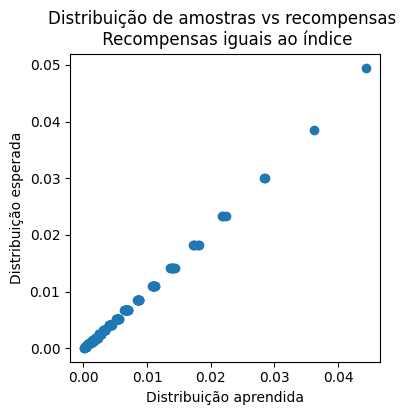

In [753]:
plt.figure(figsize=(4, 4)) 
# Compute the relative frequency of each state, and compare them to the relative reward 
_, indices, counts = np.unique(samples, axis=0, return_index=True, return_counts=True) 
plt.scatter(
    counts / counts.sum(), 
    # (rewards - torch.logsumexp(rewards)).exp() = rewards.exp() / rewards.exp().sum() = 
    # normalized rewards  
    (rewards[indices] - torch.logsumexp(rewards[indices], dim=0)).exp() 
)  
plt.xlabel('Distribuição aprendida') 
plt.ylabel('Distribuição esperada') 
plt.title('Distribuição de amostras vs recompensas \n Recompensas iguais ao índice')

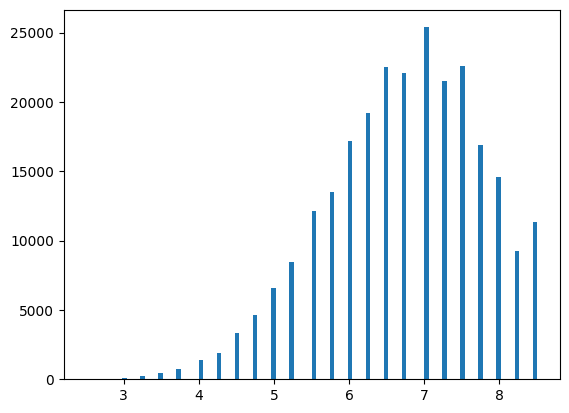

In [754]:
# make a histogram of the rewards
plt.hist(rewards, bins=100)
plt.show()

In [759]:
warehouse_array = np.zeros(warehouse_size)
for sample in samples:
    warehouse_array += sample.numpy()

warehouse_array

array([ 41490.,  50713.,  62251.,  75265.,  91211., 107278., 123344.,
       141615., 157086., 173747.])

Text(0, 0.5, 'Frequência')

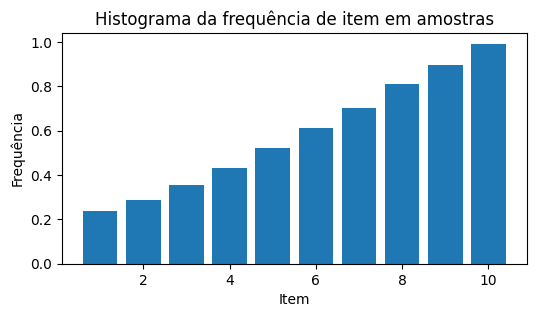

In [780]:
# make a histogram of the warehouse array
plt.figure(figsize=(6, 3))
plt.bar(np.arange(1, warehouse_size+1), warehouse_array/175000)
plt.title('Histograma da frequência de item em amostras')
plt.xlabel('Item')
plt.ylabel('Frequência')

<BarContainer object of 10 artists>

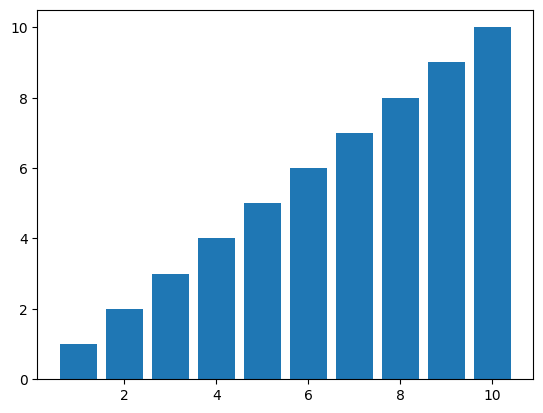

In [761]:
# plotar reward esperado
plt.figure()
plt.bar(np.arange(1, warehouse_size+1), log_reward.r.numpy())